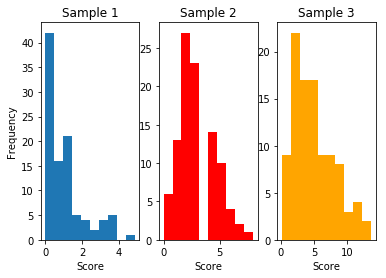


Sample 1 is not normally distributed.
NormaltestResult(statistic=32.24165141562006, pvalue=9.972736663645278e-08)

Sample 2 is normally distributed.
NormaltestResult(statistic=5.814534343029209, pvalue=0.05462480630292182)

Sample 3 is not normally distributed.
NormaltestResult(statistic=9.86896403088652, pvalue=0.007194186458417939)


,score,sample,ranks
112,0.000000,sample_2,3.5
183,0.000000,sample_2,3.5
179,0.000000,sample_2,3.5
116,0.000000,sample_2,3.5
157,0.000000,sample_2,3.5
165,0.000000,sample_2,3.5
19,0.011735,sample_1,7.0
85,0.023723,sample_1,8.0
0,0.024214,sample_1,9.0
30,0.025141,sample_1,10.0



Manually calculated Kruskal-Wallis test results:
('H = ', 126.13351217058866, 'p =', 0.0)

Kruskal-Wallis test results calculated with scipy.stats:
KruskalResult(statistic=126.13351217058866, pvalue=4.078080934368046e-28)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

pd.options.mode.chained_assignment = None  

# creating non-normal data, randomly determining which will have the larger mean rank

sample_size = 100

distributions = [np.random.chisquare(df = 5, size = sample_size), 
                 np.random.poisson(lam = 3, size = sample_size),
                np.random.gamma(shape =1, scale = 1, size = sample_size)]

distributions = np.random.permutation(distributions)

sample_1_outcome = distributions[0]
sample_2_outcome = distributions[1]
sample_3_outcome = distributions[2]

# plotting the data

fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.hist(sample_1_outcome)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')
ax.set_title('Sample 1')

ax2 = fig.add_subplot(1,3,2)
ax2.hist(sample_2_outcome, color = 'red')
ax2.set_xlabel('Score')
ax2.set_title('Sample 2')


ax3 = fig.add_subplot(1,3,3)
ax3.hist(sample_3_outcome, color = 'orange')
ax3.set_xlabel('Score')
ax3.set_title('Sample 3')
plt.show()

# checking for normality

normtest_1 = scipy.stats.normaltest(sample_1_outcome)
normtest_2 = scipy.stats.normaltest(sample_2_outcome)
normtest_3 = scipy.stats.normaltest(sample_3_outcome)

norm_tests = [normtest_1, normtest_2, normtest_3]

for i in np.arange(len(norm_tests)):
    if norm_tests[i][1] <= 0.05:
      print('\nSample '+str(i+1)+' is not normally distributed.')
      print(norm_tests[i])
    
    else:
      print('\nSample '+str(i+1)+' is normally distributed.')
      print(norm_tests[i])
      
      
# manually performing a Kruskal-Wallis H-test test

# creating a dataframe with the scores of the samples


sample_labels = np.repeat('sample_1', len(sample_1_outcome))
sample_labels = np.append(sample_labels, np.repeat('sample_2', len(sample_2_outcome)))
sample_labels = np.append(sample_labels, np.repeat('sample_3', len(sample_3_outcome)))

combined_scores = np.append(sample_1_outcome, [sample_2_outcome, sample_3_outcome])

df = pd.DataFrame({'score': combined_scores, 'sample': sample_labels})

# ranking the data by score
df.sort_values(by = 'score', inplace = True)

df['ranks'] = np.arange(1, len(df)+1)

for i in np.arange(len(df)):
    tie_indexes = np.where(df['score'] == df['score'].iloc[i])
    tied_ranks = np.mean(df['ranks'].iloc[tie_indexes])
    df['ranks'].iloc[tie_indexes] = tied_ranks
    
    

display(df.head(15))

samp_1_ranks = df[df['sample'] == 'sample_1']['ranks']
samp_2_ranks = df[df['sample'] == 'sample_2']['ranks']
samp_3_ranks = df[df['sample'] == 'sample_3']['ranks']

# writing a funtion to perform the Kruskal-Wallis H test with tied ranks correction, on 3 samples

def kruskal_w_h(samp_1_ranks, samp_2_ranks, samp_3_ranks):
    
    r_t1 = np.sum(samp_1_ranks)
    n1 = len(samp_1_ranks)
    r_t2 = np.sum(samp_2_ranks)
    n2 = len(samp_2_ranks)
    r_t3 = np.sum(samp_3_ranks)
    n3 = len(samp_3_ranks)
    N = n1 + n2 + n3
    
    r_ti_sq_over_ni = np.array([r_t1**2/n1, r_t2**2/n2, r_t3**2/n3])
    
    ith_ties = np.array([])
    tie_at_i = np.array([])
    for i in np.arange(len(df)):
        if df['ranks'].iloc[i] == df['ranks'].iloc[i-1]:
            i = i + 1
        else:
            num_ties_at_i = len(np.where(df['ranks'] == df['ranks'].iloc[i])[0])
            ith_ties = np.append(ith_ties, num_ties_at_i)
            
    ith_ties = ith_ties**3 - ith_ties      
    
    H = (12/(N*(N+1)) *  np.sum(r_ti_sq_over_ni)) - 3*(N+1)  
    
    C = 1 - np.sum(ith_ties)/((N-1)*N*(N+1))
    
    deg_free = len(r_ti_sq_over_ni) - 1
    
    p_value = 1 - scipy.stats.chi.cdf(H/C, df = deg_free)
            
    return 'H = ', H/C, 'p =', p_value

print('\nManually calculated Kruskal-Wallis test results:')
print(kruskal_w_h(samp_1_ranks, samp_2_ranks, samp_3_ranks))

print('\nKruskal-Wallis test results calculated with scipy.stats:')
print(scipy.stats.kruskal(sample_1_outcome, sample_2_outcome, sample_3_outcome))